# Object Detection



## Imports

In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
from openvino.inference_engine import IECore

## Load the Model

In [2]:
ie = IECore()

net = ie.read_network(
    model="model/horizontal-text-detection-0001.xml",
    weights="model/horizontal-text-detection-0001.bin",
)
exec_net = ie.load_network(net, "CPU")

output_layer_ir = next(iter(exec_net.outputs))
input_layer_ir = next(iter(exec_net.input_info))

## Load an Image

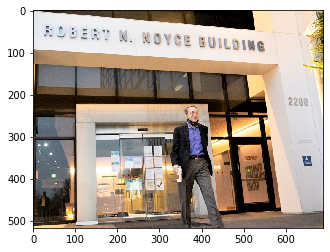

In [3]:
# Text detection models expects image in BGR format
image = cv2.imread("data/rnb.jpg")

# N,C,H,W = batch size, number of channels, height, width
N, C, H, W = net.input_info[input_layer_ir].tensor_desc.dims

# Resize image to meet network expected input sizes
resized_image = cv2.resize(image, (W, H))

# Reshape to network input shape
input_image = np.expand_dims(resized_image.transpose(2, 0, 1), 0)

plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB));

## Do Inference

In [4]:
result = exec_net.infer(inputs={input_layer_ir: input_image})

# Extract list of boxes from results
boxes = result["boxes"]

# Remove zero only boxes
boxes = boxes[~np.all(boxes == 0, axis=1)]

## Visualize Results

In [5]:
# For each detection, the description has the format: [x_min, y_min, x_max, y_max, conf]
# Image passed here is in BGR format with changed width and height. To display it in colors expected by matplotlib we use cvtColor funtion
def convert_result_to_image(bgr_image, resized_image, boxes, threshold=0.3, conf_labels=True):
    # Helper function to multiply shape by ratio
    def multiply_by_ratio(ratio_x, ratio_y, box):
        return [
            max(shape * ratio_y, 10) if idx % 2 else shape * ratio_x
            for idx, shape in enumerate(box[:-1])
        ]

    # Define colors for boxes and descriptions
    colors = {"red": (255, 0, 0), "green": (0, 255, 0)}

    # Fetch image shapes to calculate ratio
    (real_y, real_x), (resized_y, resized_x) = image.shape[:2], resized_image.shape[:2]
    ratio_x, ratio_y = real_x / resized_x, real_y / resized_y

    # Convert base image from bgr to rgb format
    rgb_image = cv2.cvtColor(bgr_image, cv2.COLOR_BGR2RGB)

    # Iterate through non-zero boxes
    for box in boxes:
        # Pick confidence factor from last place in array
        conf = box[-1]
        if conf > threshold:
            # Convert float to int and multiply position of each box by x and y ratio
            (x_min, y_min, x_max, y_max) = map(int, multiply_by_ratio(ratio_x, ratio_y, box))

            # Draw box based on position, parameters in rectangle function are: image, start_point, end_point, color, thickness
            rgb_image = cv2.rectangle(rgb_image, (x_min, y_min), (x_max, y_max), colors["green"], 3)

            # Add text to image based on position and confidence
            # Parameters in text function are: image, text, bottomleft_corner_textfield, font, font_scale, color, thickness, line_type
            if conf_labels:
                rgb_image = cv2.putText(
                    rgb_image,
                    f"{conf:.2f}",
                    (x_min, y_min - 10),
                    cv2.FONT_HERSHEY_SIMPLEX,
                    0.8,
                    colors["red"],
                    1,
                    cv2.LINE_AA,
                )

    return rgb_image

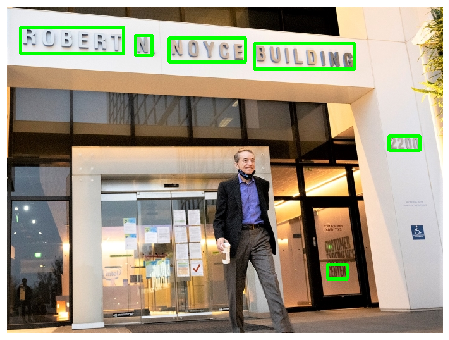

In [6]:
plt.figure(figsize=(10, 6))
plt.axis("off")
plt.imshow(convert_result_to_image(image, resized_image, boxes, conf_labels=False));